In [121]:
# Imports (YOU MUST INSTALL OBSPY FIRST)

from obspy               import *
from obspy.clients        import fdsn
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors   import Normalize
from obspy.geodetics.base       import gps2dist_azimuth
from obspy.geodetics import locations2degrees
from obspy.clients.fdsn    import Client
import os
import obspy.signal.array_analysis as AA
import matplotlib.pyplot           as plt
plt.rcParams["figure.figsize"] = (10,6)
import matplotlib.cm               as cm
import numpy                       as np
import scipy                       as sp
import scipy.odr                   as odr
import math
import obspy
from obspy.core.util.obspy_types import CustomComplex
from obspy.signal.rotate import rotate2zne
import warnings
warnings.filterwarnings("ignore")
#Events
from obspy import read_events
##### for map
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#####

catalog= read_events("./quake_paper.xml")

event=catalog[8]
ev_N=len(catalog)

print(' Origin time: ',event.origins[0].time)
print(' Latitude: ',event.origins[0].latitude)
print(' Longitude: ',event.origins[0].longitude)
print(' Depth: ',event.origins[0].depth)
print(' Magnitude: ',event.magnitudes[0])



fdsn_client = Client('IRIS')
save_path = "./output/"

starttime = UTCDateTime("2023-06-16T14:36")


#PFO array information, misorientations for correction, array options
network = 'PY'
#array_stations =     ['PFOIX','BPH01','BPH02','BPH03','BPH04']
array_stations =     ['BPH01','BPH02','BPH03','BPH04','BPH05','BPH06','BPH07','BPH08','BPH09','BPH10','BPH11','BPH12','BPH13']
misorientations=      [0.     ,-1.375 ,0.25   ,0.125  ,-0.6875,-0.625 ,-1.9375,0.375  ,-6.5625,0.3125 ,-1.125 ,-2.5625,0.1875]  
array_station=[]
misorientation=[]
#array used
#array=[0,3,2,1,4] #small 
array =  [2,1,0,3,4,5,6,7] #all


# Setting up array coordinates, defining frequency range
for i in array:
    array_station.append(array_stations[i])
    #misorientation.append(misorientations[i])
    
    
subarray = range(0,len(array_station))


bpf=True
channel_resp='BHZ'
debug=True


#create relative distance of array
coo = []
first = True
for station in array_station:
    inven =  fdsn_client.get_stations(network=network,station=station,channel='BHZ',starttime=starttime,endtime=starttime+86400,level='response') 
    l_lon =  float(inven.get_coordinates('%s.%s..BHZ'%(network,station))['longitude'])
    l_lat =  float(inven.get_coordinates('%s.%s..BHZ'%(network,station))['latitude'])
    height = float(inven.get_coordinates('%s.%s..BHZ'%(network,station))['elevation'])

    if first:
        first = False 
        o_lon = l_lon
        o_lat = l_lat
        o_height = height
    lon,lat = obspy.signal.util.util_geo_km(o_lon,o_lat,l_lon,l_lat)  
    coo.append([lon*1000,lat*1000,height-o_height])  #convert unit from km to m

#print(coo) 




 Origin time:  2017-07-17T23:34:13.740000Z
 Latitude:  54.4434
 Longitude:  168.857
 Depth:  10000.0
 Magnitude:  Magnitude
	     resource_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/origin/us20009x42/us/1507683831040/product.xml#magnitude")
	             mag: 7.7 [uncertainty=0.036]
	  magnitude_type: 'mww'
	       origin_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/origin/us20009x42/us/1507683831040/product.xml")
	   station_count: 73
	 evaluation_mode: 'manual'
	   creation_info: CreationInfo(agency_id='us', creation_time=UTCDateTime(2017, 10, 11, 1, 3, 51, 40000))


(array([-400., -200.,    0.,  200.,  400.]),
 <a list of 5 Text major ticklabel objects>)

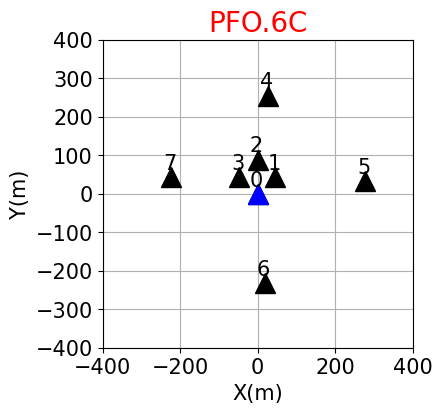

In [84]:
plt.figure(figsize=(4, 4))
for i in range(0,len(array)):
#     plt.subplot(2,1,1)
    plt.plot(coo[i][0],coo[i][1],'k^',markersize=15)
#     plt.subplot(2,1,2)
#     plt.plot(i,np.sqrt(coo[i][0]**2+coo[i][1]**2),'ko')
    plt.text(coo[i][0]-20,coo[i][1]+20,'%d'%(i),fontsize=15)
# plt.subplot(2,1,1)
plt.plot(coo[0][0],coo[0][1],'b^',markersize=15)
#plt.text(coo[0][0]-120,coo[0][1]-60,'Central Station',fontsize=20,color='r')
plt.xlabel('X(m)',fontsize=15)

plt.ylabel('Y(m)',fontsize=15)
# plt.set_xlabel(fontsize=18,labelpad = 12.5)
plt.xlim(-400,400)
plt.ylim(-400,400)
plt.title('PFO.6C',fontsize=20,color='r')
plt.grid()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

Text(168.857, 49.4434, 'Mg=7.7')

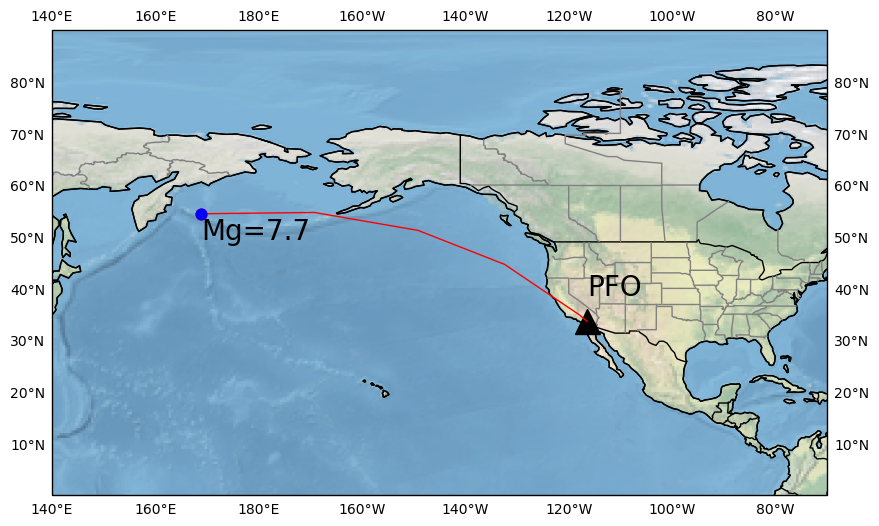

In [145]:
central_longitude0=-160
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_longitude0))
# ax.set_extent([20, -120, 0, 80]) 
# ax.set_ylim([0, 80])
ax.set_extent([90, -90, -90, 90])
ax.set_ylim([-0, 90])
ax.set_xlim([-60, 90])

# ax.coastlines(resolution='11m')
ax.stock_img()
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')

gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                  draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--') 


# gl.xlabels_top = False
# gl.xlabels_bottom = False
# gl.ylabels_left = False
gl.xlines = False
gl.ylines = False
gl.xlocator = mticker.FixedLocator([140,160,180,-160,-140,-120,-100,-80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'size': 15, 'color': 'gray'}
# gl.xlabel_style = {'color': 'red', 'weight': 'bold'}


ff_lat=o_lat
ff_lon=o_lon

# ax.plot([to_lon, ff_lon], [to_lat, ff_lat], c='b', lw=2,
#         transform=ccrs.PlateCarree())


## plot station and earthquake
ax.plot(ff_lon,ff_lat,'k^',markersize=18,transform=ccrs.Geodetic())
ax.text(ff_lon,ff_lat+5,'PFO',transform=ccrs.Geodetic(),fontsize=20)

"""
for i in range(0,ev_N):
    to_lat=catalog[i].origins[0].latitude
    to_lon=catalog[i].origins[0].longitude
    ax.plot(to_lon,to_lat,'bo',markersize=catalog[i].magnitudes[0].mag,transform=ccrs.Geodetic())
    ax.text(to_lon,to_lat-5,'%.1f'%(catalog[i].magnitudes[0].mag),transform=ccrs.Geodetic())
    ax.text(to_lon,to_lat-10,'%.1f'%(i),transform=ccrs.Geodetic())
    ax.plot([to_lon, ff_lon], [to_lat, ff_lat], c='k', lw=1,
        transform=ccrs.Geodetic())
"""
i=8
to_lat=event.origins[0].latitude
to_lon=event.origins[0].longitude
ax.plot(to_lon,to_lat,'ro',markersize=catalog[i].magnitudes[0].mag,transform=ccrs.Geodetic())
ax.plot([to_lon, ff_lon], [to_lat, ff_lat], c='r', lw=1,
        transform=ccrs.Geodetic())
ax.plot(to_lon,to_lat,'bo',markersize=catalog[i].magnitudes[0].mag,transform=ccrs.Geodetic())
ax.text(to_lon,to_lat-5,'Mg=%.1f'%(catalog[i].magnitudes[0].mag),transform=ccrs.Geodetic(),fontsize=20)


In [130]:
# Single Event Data, collect array data for single event

# Start time, end time
# 2022-03-16 14:36:30 (UTC) M 7 in Japan
#starttime for data processing
#prefilt=(0.001, 0.006, 10, 20)
prefilt=(0.001, 0.002, 10, 20)

# 
# This section is important, here you determine the frequency range for the plots

# Original
#freq1=0.014   #0.014 for Spudich    and  0.073 for Langston
#freq2=1.5  


freq1=1./40  #period=100s
freq2=1./20  #period=10s
#starttime = UTCDateTime("2021-07-29T06:07:20.000")+1000
starttime = event.origins[0].time+500
# starttime = event.origins[0].time+3600*4
t=starttime; e=t+2500 #hour data


print(t,e)
tsz = []
tsn = []
tse = []      
first = True
for station in array_station:
    mystream = fdsn_client.get_waveforms(network,station,'','BH*',t,e,attach_response=True)
    print(' '+station+'..done') 
    mystream.sort()
    mystream.reverse() 
    mystream.remove_response(output="VEL",pre_filt=prefilt,taper=False,zero_mean=True)
    #mystream[0].data, mystream[1].data, mystream[2].data=rotate2zne(mystream[0],0,-90,mystream[1],misorientation[array_station.index(station)],0,mystream[2],90+misorientation[array_station.index(station)],0)    #correct mis-alignment
    mystream.detrend('linear')
    mystream.taper(max_percentage=0.05,type='cosine')
    mystream.filter('bandpass',freqmin=freq1,freqmax=freq2,corners=2,zerophase=True) if bpf == True else None

    mystream.resample(4.0)
    
    if first:
        first = False
        print(' Initializing central station to acc')
        o_mystream=mystream.copy()     #information of the central station   
        acc = mystream.copy()
        acc.differentiate()          
    tsz.append(mystream[0].data)
    tsn.append(mystream[1].data)
    tse.append(mystream[2].data)        

print(' Array data retrieval is done...') 
print(' Plotting and checking data...') 




2017-07-17T23:42:33.740000Z 2017-07-18T00:24:13.740000Z
 BPH03..done
 Initializing central station to acc
 BPH02..done
 BPH01..done
 BPH04..done
 BPH05..done
 BPH06..done
 BPH07..done
 BPH08..done
 Array data retrieval is done...
 Plotting and checking data...


(0.0001, -0.0001)

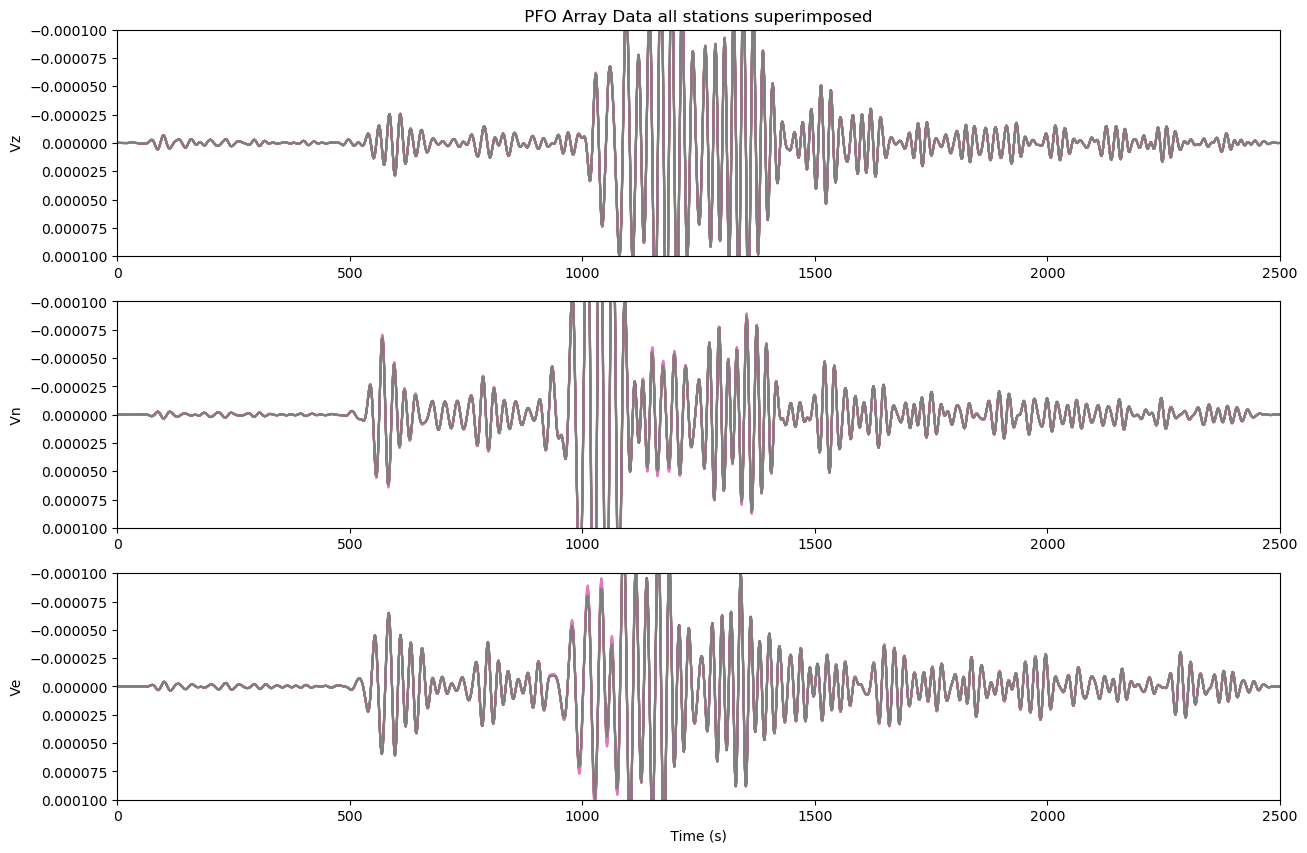

In [131]:
# initialize time
time = np.linspace(0,1./mystream[0].stats.sampling_rate*mystream[0].stats.npts,mystream[0].stats.npts)


x1=0
x2=2500*1
y1=1e-4
y2=-1e-4
plt.figure(figsize=(15,10))
ax=plt.subplot(311)
plt.plot(time,np.transpose(tsz))

plt.title(' PFO Array Data all stations superimposed ')
plt.ylabel(' Vz ')
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax=plt.subplot(312)
plt.plot(time,np.transpose(tsn))
plt.ylabel(' Vn ')

ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax=plt.subplot(313)
plt.plot(time,np.transpose(tse))
plt.ylabel(' Ve ')
plt.xlabel(' Time (s) ')
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)

#print(mystream[0].stats)

In [132]:
# Array derivation with PFO data

#perform array-derivation
print(' ADR is executing...')
ttse  =  np.array(tse)
ttsn  =  np.array(tsn)
ttsz  =  np.array(tsz)
vp = 6264. #1700
vs = 3751. #1000
sigmau = 0.001 #0.001

# Call the ObsPy ADR routine 
result = AA.array_rotation_strain(np.array(subarray), np.transpose(ttse), np.transpose(ttsn), np.transpose(ttsz), vp, vs, np.array(coo), sigmau)


# Remap output
rotz = result['ts_w3']
rotn = result['ts_w2']
rote = result['ts_w1']

#(Rotation trace)
rot = o_mystream                  #information of the central station 
rot[0].data = rotz
rot[1].data = rotn
rot[2].data = rote
rot[0].stats.channel='BJZ'
rot[1].stats.channel='BJN'
rot[2].stats.channel='BJE'
      
print(' ADR is done ... takes time ...')




 ADR is executing...
 ADR is done ... takes time ...


In [133]:
# Prepare rotation to RTZ 

# event location from event info
source_latitude = event.origins[0].latitude
source_longitude = event.origins[0].longitude

# station location (PFO)
station_latitude = o_lat
station_longitude = o_lon

# theoretical backazimuth and distance
baz = gps2dist_azimuth(source_latitude, source_longitude, station_latitude, station_longitude)

print('Epicentral distance [km]: ', baz[0]/1000)
print('Theoretical azimuth [deg]: ', baz[1])
print('Theoretical backazimuth [deg]: ', baz[2])

# I implemented this rotation, I hope it is correct, it seems to work for Rayleigh
acc1=acc
rot1=rot
#acc1.rotate(method='NE->RT',back_azimuth=baz[2]) 
#rot1.rotate(method='NE->RT',back_azimuth=baz[2])
print(rot1)

Epicentral distance [km]:  6092.878192516944
Theoretical azimuth [deg]:  79.84160719056491
Theoretical backazimuth [deg]:  316.51920715876867
3 Trace(s) in Stream:
PY.BPH03..BJZ | 2017-07-17T23:42:33.750000Z - 2017-07-18T00:24:13.500000Z | 4.0 Hz, 10000 samples
PY.BPH03..BJN | 2017-07-17T23:42:33.750000Z - 2017-07-18T00:24:13.500000Z | 4.0 Hz, 10000 samples
PY.BPH03..BJE | 2017-07-17T23:42:33.750000Z - 2017-07-18T00:24:13.500000Z | 4.0 Hz, 10000 samples


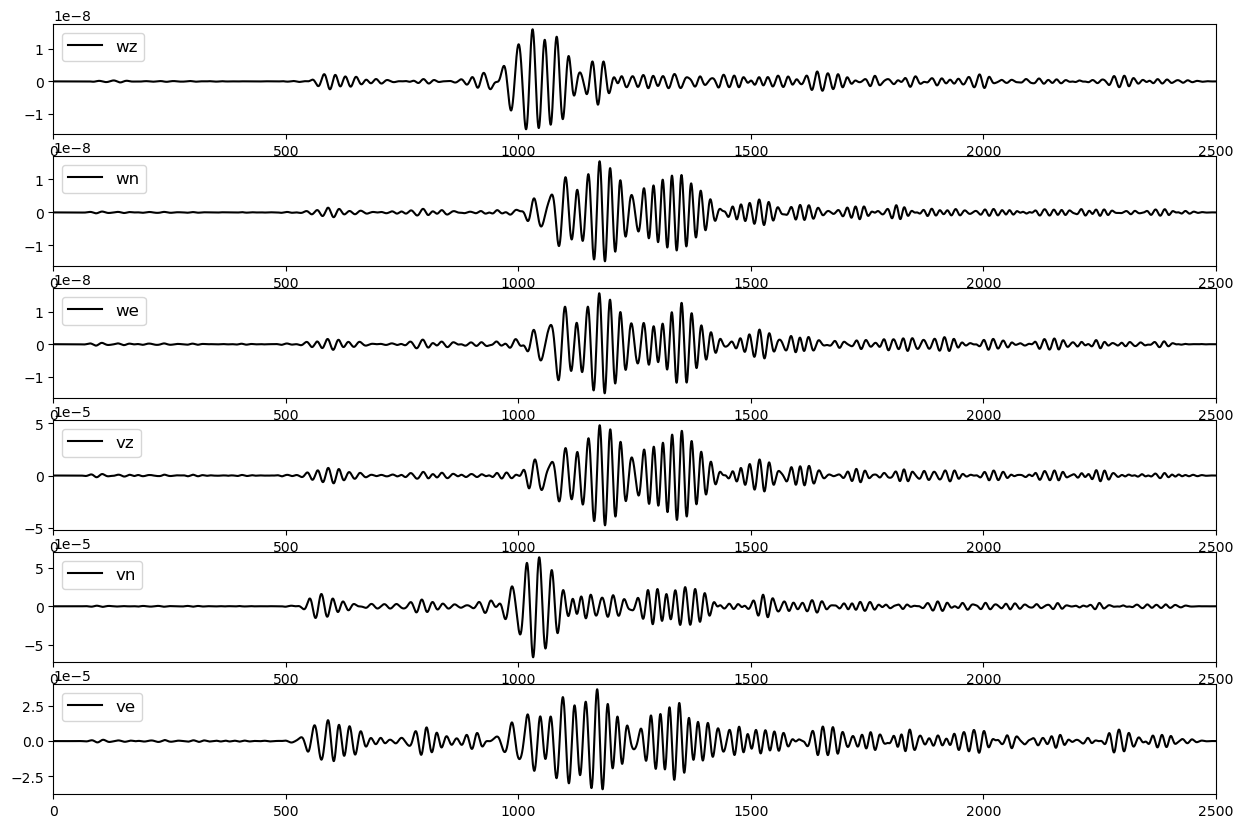

In [134]:
plt.figure(figsize=(15,10))

x1=0
x2=2500*1

ax = plt.subplot(611)
ax.plot(rot1[0].times(), rot1[0].data, 'k', label='wz')
ax.set_xlim(x1,x2)
ax.legend(loc=2, prop={"size":12})
ax = plt.subplot(612)
ax.plot(rot1[1].times(), rot1[1].data, 'k', label='wn')
ax.set_xlim(x1,x2)
ax.legend(loc=2, prop={"size":12})
ax = plt.subplot(613)
ax.plot(rot1[2].times(), rot1[2].data, 'k', label='we')
ax.set_xlim(x1,x2)
ax.legend(loc=2, prop={"size":12})

ax = plt.subplot(614)
ax.plot(acc1[0].times(), acc1[0].data, 'k', label='vz')
ax.set_xlim(x1,x2)
ax.legend(loc=2, prop={"size":12})
ax = plt.subplot(615)
ax.plot(acc1[1].times(), acc1[1].data, 'k', label='vn')
ax.set_xlim(x1,x2)
ax.legend(loc=2, prop={"size":12})
ax = plt.subplot(616)
ax.plot(acc1[2].times(), acc1[2].data, 'k', label='ve')
ax.set_xlim(x1,x2)
ax.legend(loc=2, prop={"size":12})

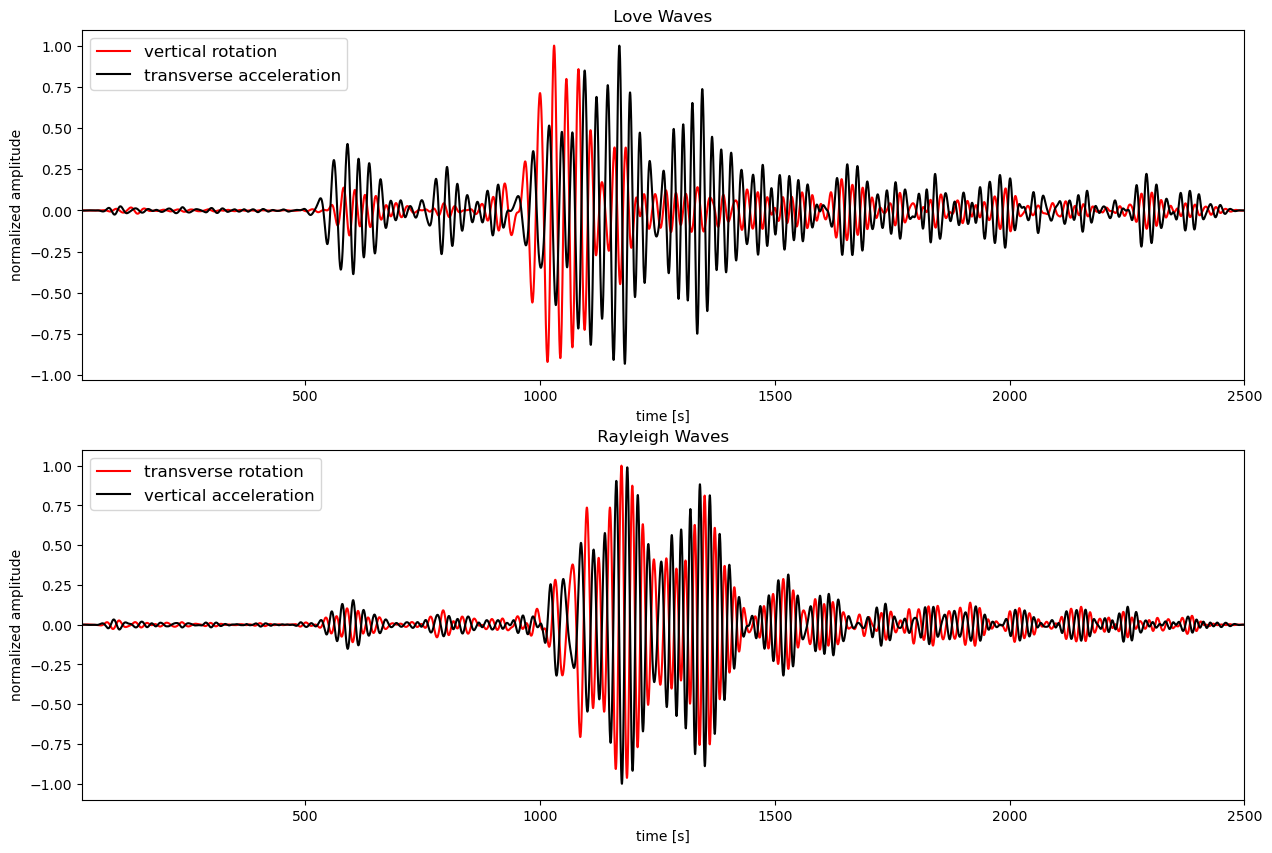

In [135]:
plt.figure(figsize=(15,10))

x1=25
x2=2500*1


ax = plt.subplot(211)
ax.plot(rot1[0].times(), rot1[0].data/np.max(np.abs(rot1[0].data)), 'r', label='vertical rotation')
ax.plot(acc1[2].times(), acc1[2].data/np.max(np.abs(acc1[2].data)), 'k', label='transverse acceleration')
ax.legend(loc=2, prop={"size":12})
ax.set_xlabel('time [s]')
ax.set_ylabel('normalized amplitude')
ax.set_xlim(x1,x2)
# ax.set_ylim(-0.03,0.03)
ax.set_title(' Love Waves ')

ax = plt.subplot(212)
ax.plot(rot1[2].times(), rot1[2].data/np.max(np.abs(rot1[2].data)), 'r', label='transverse rotation')
ax.plot(acc1[0].times(), -acc1[0].data/np.max(np.abs(acc1[0].data)), 'k', label='vertical acceleration')
ax.legend(loc=2, prop={"size":12})
ax.set_xlabel('time [s]')
ax.set_ylabel('normalized amplitude')
ax.set_xlim(x1,x2)
# ax.set_ylim(-0.03,0.03)
ax.set_title(' Rayleigh Waves ')

plt.show()


In [136]:

from obspy import read
rot1[0].write('./Rot_z_PFO.mseed',format='MSEED')
rot1[1].write('./Rot_x_PFO.mseed',format='MSEED')
rot1[2].write('./Rot_y_PFO.mseed',format='MSEED')

acc1[0].write('./Tra_z_PFO.mseed',format='MSEED')
acc1[1].write('./Tra_x_PFO.mseed',format='MSEED')
acc1[2].write('./Tra_y_PFO.mseed',format='MSEED')
print(rot1[0].stats)


               network: PY
               station: BPH03
              location: 
               channel: BJZ
             starttime: 2017-07-17T23:42:33.750000Z
               endtime: 2017-07-18T00:24:13.500000Z
         sampling_rate: 4.0
                 delta: 0.25
                  npts: 10000
                 calib: 1.0
_fdsnws_dataselect_url: http://service.iris.edu/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'M', 'number_of_records': 269, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 406016})
            processing: ['ObsPy 1.2.2: trim(endtime=UTCDateTime(2017, 7, 18, 0, 24, 13, 750000)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2017, 7, 17, 23, 42, 33, 750000))', "ObsPy 1.2.2: remove_response(fig=None::inventory=None::output='VEL'::plot=False::pre_filt=(0.001, 0.002, 10, 20)::taper=False::taper_fraction=0.05::water_level=60::zero_mean=True)", "ObsPy 1.2.2: d